# 03. Modeling — Uruguay Census 2023

This notebook focuses on the **modeling stage** of the Uruguay 2023 Census project.

**Objective of the Modeling Stage**

In this stage we move from **exploratory analysis** to **predictive modeling** using the 2023 Uruguay Census microdata.

The main goal is to build and evaluate baseline **supervised learning models** that predict whether an individual is **working or not**, using a small, interpretable set of demographic predictors:

- `works` (target) — binary labor activity indicator  
  - `1` = employed (*trabaja*)  
  - `2` = not employed (*no trabaja*)
- `sex` — biological sex  
  - `1` = male (*hombre*)  
  - `2` = female (*mujer*)
- `age_years` — age in years (numeric)
- `education` — highest educational level attained (categorical)
- `departament` — department of residence in Uruguay (categorical, 1–19)

### **1. Imports and Spark session**


In [1]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col

from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import (
    LogisticRegression,
    DecisionTreeClassifier as PyDecisionTreeClassifier   
)
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

from sklearn.tree import DecisionTreeClassifier as SkDecisionTreeClassifier, plot_tree 

from pyspark.ml.feature import OneHotEncoder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




In [2]:
spark = SparkSession.builder \
    .config("spark.driver.memory", "2g") \
    .appName("MyApp") \
    .getOrCreate()

### **2. Load clean dataset**


In [3]:
sdf_clean = spark.read.parquet("dataset/personas_clean.parquet")

In [4]:
sdf_clean.printSchema()

root
 |-- ID: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- works: integer (nullable = true)
 |-- education: integer (nullable = true)
 |-- municipality: string (nullable = true)
 |-- departament: integer (nullable = true)



In [5]:
sdf_clean.show(5, truncate=False)

+--------+---+---+-----+---------+------------+-----------+
|ID      |age|sex|works|education|municipality|departament|
+--------+---+---+-----+---------+------------+-----------+
|669146.0|71 |2  |0    |NULL     |Municipio CH|1          |
|669147.0|55 |2  |0    |NULL     |Municipio CH|1          |
|669148.0|69 |1  |1    |NULL     |Municipio CH|1          |
|669149.0|24 |2  |0    |NULL     |Municipio CH|1          |
|669150.0|65 |1  |1    |NULL     |Municipio CH|1          |
+--------+---+---+-----+---------+------------+-----------+
only showing top 5 rows


## **3. Utility functions**

In [6]:
def train_test_split(df, ratio=0.8, seed=42):
    """Spark random split wrapper."""
    train, test = df.randomSplit([ratio, 1-ratio], seed=seed)
    print(f"Train: {train.count()}, Test: {test.count()}")
    return train, test


def evaluate_binary(pred_df, label="label", pred="prediction"):
    """Accuracy and ROC-AUC for binary classifiers."""
    acc_eval = MulticlassClassificationEvaluator(
        labelCol=label, predictionCol=pred, metricName="accuracy"
    )
    auc_eval = BinaryClassificationEvaluator(
        labelCol=label, rawPredictionCol="rawPrediction"
    )
    acc = acc_eval.evaluate(pred_df)
    auc = auc_eval.evaluate(pred_df)
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC:  {auc:.4f}")
    return acc, auc


def confusion_matrix(pred_df, label="label", pred="prediction"):
    """Return confusion matrix as Pandas DF."""
    cm = (
        pred_df.groupBy(label, pred)
        .count()
        .toPandas()
        .pivot(index=label, columns=pred, values="count")
        .fillna(0)
        .astype(int)
    )
    cm.index.name = "True"
    cm.columns.name = "Predicted"
    return cm


In [7]:
sdf_clean.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+------------+-----------------+
|summary|                ID|               age|               sex|             works|        education|municipality|      departament|
+-------+------------------+------------------+------------------+------------------+-----------------+------------+-----------------+
|  count|           2884797|           2884797|           2884797|           2176830|           677243|     2884797|          2884797|
|   mean|1665069.1938517685|38.321099543572736|1.5199703826647075|0.5236706587101427|4.776456899517603|      9898.0|5.397855724336929|
| stddev| 1049117.279230784| 22.93406820381167|0.4996011112269681|0.4994395003449246|2.767093295591229|         0.0|5.656911387224959|
|    min|               1.0|                 0|                 1|                 0|                1|  18 de Mayo|                1|
|    max|         3499450.0|               109|        

## **4. Define modeling dataset**

In this section we define the subset of variables used for modeling:

- Target: `works` (0/1)
- Predictors: `age`, `sex`, `education`

We also:
- filter out rows with missing values in these variables
- rename `works` to `label` for compatibility with Spark ML

----

## Objective of the Modeling Stage

The goal of this modeling stage is to **predict whether an individual is currently working (label = 1) or not (label = 0)** using only the demographic information available in the cleaned census dataset.

Specifically, we aim to:

1. **Build a baseline predictive model** using three core demographic variables:
   - `age`
   - `sex`
   - `education`
   - `departament`

2. **Compare linear vs. non-linear approaches**:
   - Logistic Regression (interpretable, baseline)
   - Decision Tree Classifier (non-linear alternative with feature importance)

4. **Establish a clean, reproducible modeling workflow** aligned with the EDA and Preprocessing stages:
   - feature assembly  
   - standardization  
   - train/test split  
   - model training  
   - evaluation

5. **Identify limitations and areas for improvement**, guiding the next iterations of the project.

This stage serves as the project's first modeling iteration, providing a clear understanding of how far we can go with minimal demographic information and setting the foundation for more advanced models and richer feature sets.



In [8]:
missing_counts = sdf_clean.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in sdf_clean.columns
])

missing_counts.show(truncate=False)


+---+---+---+------+---------+------------+-----------+
|ID |age|sex|works |education|municipality|departament|
+---+---+---+------+---------+------------+-----------+
|0  |0  |0  |707967|2207554  |0           |0          |
+---+---+---+------+---------+------------+-----------+



In [9]:
sdf_clean = sdf_clean.dropna()

In [10]:
missing_counts = sdf_clean.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in sdf_clean.columns
])

missing_counts.show(truncate=False)


+---+---+---+-----+---------+------------+-----------+
|ID |age|sex|works|education|municipality|departament|
+---+---+---+-----+---------+------------+-----------+
|0  |0  |0  |0    |0        |0           |0          |
+---+---+---+-----+---------+------------+-----------+



In [11]:
sdf_clean.describe().show()

+-------+------------------+------------------+-------------------+-------------------+------------------+------------+-----------------+
|summary|                ID|               age|                sex|              works|         education|municipality|      departament|
+-------+------------------+------------------+-------------------+-------------------+------------------+------------+-----------------+
|  count|            431315|            431315|             431315|             431315|            431315|      431315|           431315|
|   mean|1394922.7138008184| 22.22648180564089| 1.5490604314711987| 0.3053754216755735| 6.482603201836245|        NULL|4.923812063109328|
| stddev| 938803.7473467832|10.650285721995893|0.49758782954121217|0.46056678702927556|1.9714562957850654|        NULL|5.497324834744584|
|    min|              57.0|                12|                  1|                  0|                 2|  18 de Mayo|                1|
|    max|         3138813.0|      

## **5. Prepare modeling dataset**
We keep only the variables required for modeling:

- target: `works` → renamed to `label`  
- predictors: `age`, `sex`, `education`, `departament`

We also remove rows with missing values in any of these fields.

In [12]:
TARGET = "works"
FEATURES = ["age", "sex", "education", "departament"]
FEATURES_LR = ["age", "departament", "sex_ohe", "education_ohe"]

sdf_model = sdf_clean.select([TARGET] + FEATURES)

sdf_model = sdf_model.dropna(subset=[TARGET] + FEATURES)

sdf_model = sdf_model.withColumnRenamed("works", "label")

sdf_model.show(5)
print("Model rows:", sdf_model.count())


+-----+---+---+---------+-----------+
|label|age|sex|education|departament|
+-----+---+---+---------+-----------+
|    0| 15|  2|        6|          1|
|    0| 14|  2|        5|          1|
|    0| 17|  1|        6|          1|
|    1| 22|  1|        9|          1|
|    0| 16|  2|        6|          1|
+-----+---+---+---------+-----------+
only showing top 5 rows
Model rows: 431315


## **6. Train/Test split**

To obtain **honest estimates of predictive performance**, the data is split into:

- **Training set** — used to fit the models.
- **Test set** — held out and used only for final evaluation.


In [13]:
train_df, test_df = train_test_split(sdf_model)

Train: 344878, Test: 86437


## **7. Modeling pipeline — assembler + scaler + logistic regression**

The first baseline model is a **Logistic Regression classifier**, a standard choice for binary outcomes in labor market and socio-demographic research.

This pipeline performs:

1. Feature assembly  
2. Feature standardization  
3. Logistic Regression training  




In [14]:
assembler = VectorAssembler(
    inputCols=FEATURES,
    outputCol="features"
)


indexer_sexo = StringIndexer(inputCol="sex", outputCol="sex_index")
indexer_edu  = StringIndexer(inputCol="education", outputCol="education_index")

encoder = OneHotEncoder(
    inputCols=["sex_index", "education_index"],
    outputCols=["sex_ohe", "education_ohe"]
)

assembler_lr = VectorAssembler(
    inputCols=FEATURES_LR,
    outputCol="features"
)


scaler = StandardScaler(
    inputCol="features",
    outputCol="features_scaled",
    withStd=True,
    withMean=True
)

lr = LogisticRegression(
    featuresCol="features_scaled",
    labelCol="label",
    maxIter=20
)

pipeline_lr = Pipeline(stages=[
    indexer_sexo,
    indexer_edu,
    encoder,
    assembler_lr,
    scaler,
    lr
])

lr_model = pipeline_lr.fit(train_df)

train_pred = lr_model.transform(train_df)
test_pred  = lr_model.transform(test_df)

print("=== Logistic Regression (Train) ===")
evaluate_binary(train_pred)

print("\n=== Logistic Regression (Test) ===")
evaluate_binary(test_pred)



=== Logistic Regression (Train) ===
Accuracy: 0.8379
ROC-AUC:  0.9035

=== Logistic Regression (Test) ===
Accuracy: 0.8362
ROC-AUC:  0.9040


(0.8361581267281373, 0.9039783686827741)


The logistic regression model shows strong and stable performance across both the training and test sets.

- The **accuracy remains consistent** between training and test data, indicating that the model is not overfitting and generalizes well to unseen observations.
- The **ROC-AUC scores above 0.90** demonstrate excellent discriminative ability. This means the model can reliably distinguish between individuals who work and those who do not.
- Given that the model uses only a few demographic variables (age, sex, education), achieving this level of predictive power indicates that these features capture meaningful patterns related to labor participation.

### **Conclusion**
The model provides a robust baseline for predicting employment status using simple demographic characteristics. 


In [15]:
print("\n=== Confusion Matrix ===")
confusion_matrix(test_pred)


=== Confusion Matrix ===


Predicted,0.0,1.0
True,,
0,55032,4637
1,9525,17243


- **True Negatives (55,032):**  
  Individuals who *do not work* and were correctly classified.
  
- **False Positives (4,637):**  
  Individuals who *do not work*, but the model incorrectly predicted they *do work*.

- **False Negatives (9,525):**  
  Individuals who *do work*, but the model predicted *does not work*.

- **True Positives (17,243):**  
  Individuals who *do work* and were correctly classified.

### **Model Behavior Insights**
- The model performs well at identifying people who **do not work** (high True Negative count).  
- There is a noticeable number of **false negatives** (9,525), suggesting that the model occasionally misses individuals who *do work*.  
- The balance between true positives and false positives indicates a reasonable discrimination ability, consistent with the high ROC-AUC observed earlier.

### **Conclusion**
The model shows strong classification performance overall, with more difficulty in correctly identifying employed individuals (class 1) than non-employed (class 0). This pattern is typical when class distributions are imbalanced or when demographic variables only partially capture employment behavior.



## **9. Decision Tree baseline**

A simple non-linear model to compare with Logistic Regression.


In [16]:
dt = PyDecisionTreeClassifier(
    featuresCol="features",
    labelCol="label",
    maxDepth=5,
    minInstancesPerNode=500
)

pipeline_dt = Pipeline(stages=[assembler, dt])
dt_model = pipeline_dt.fit(train_df)

test_dt_pred = dt_model.transform(test_df)

print("=== Decision Tree (Test) ===")
evaluate_binary(test_dt_pred)



=== Decision Tree (Test) ===
Accuracy: 0.8560
ROC-AUC:  0.6678


(0.8559528905445585, 0.6677919262222616)

**Accuracy (85.6%)**  
The decision tree achieves a relatively high accuracy, indicating that it correctly classifies a large portion of the test samples. However, accuracy alone can be misleading, especially when classes are imbalanced or when a model relies heavily on simple decision rules.

**ROC-AUC (0.6678)**  
The ROC-AUC score tells a different story.  
A value of **0.66** reflects **only moderate discriminative ability**, meaning the model struggles to reliably distinguish between individuals who *work* and those who *do not work*.

This performance is **significantly weaker** than the logistic regression model, which achieved a ROC-AUC above 0.90. The decision tree is likely limited by:

- The small set of predictive features available  
- Categorical variables being only indexed (not one-hot encoded)  
- The inherently piecewise, rule-based nature of decision trees, which may not capture more nuanced relationships in the data

### **Conclusion**
Although the decision tree shows a seemingly strong accuracy, its low ROC-AUC indicates that its overall predictive quality is limited. Compared to the logistic regression model, it is clearly less effective at distinguishing between the two classes and is therefore not the preferred model for this task.


In [17]:
confusion_matrix(test_dt_pred)


Predicted,0.0,1.0
True,,
0,52068,7601
1,4850,21918


- **True Negatives (52,068):**  
  Individuals who *do not work* and were correctly classified as such.

- **False Positives (7,601):**  
  Individuals who *do not work* but the model incorrectly predicted they *work*.

- **False Negatives (4,850):**  
  Individuals who *do work* but were predicted as *not working*.

- **True Positives (21,918):**  
  Individuals who *do work* and were correctly identified.

### **Model Behavior Insights**
- The model performs well in identifying individuals who **work** (high number of true positives).
- There are **more false positives (7,601)** than false negatives, meaning the model is more likely to *overpredict* that someone works.
- Combined with the ROC-AUC score (~0.66), this matrix indicates that while the model captures some structure in the data, it still struggles to reliably distinguish between the two classes.

### **Conclusion**
The decision tree correctly classifies the majority of cases but shows notable misclassification rates, especially among individuals who do not work. These errors contribute to its moderate discriminative performance and reinforce that the model is less effective than the logistic regression baseline.


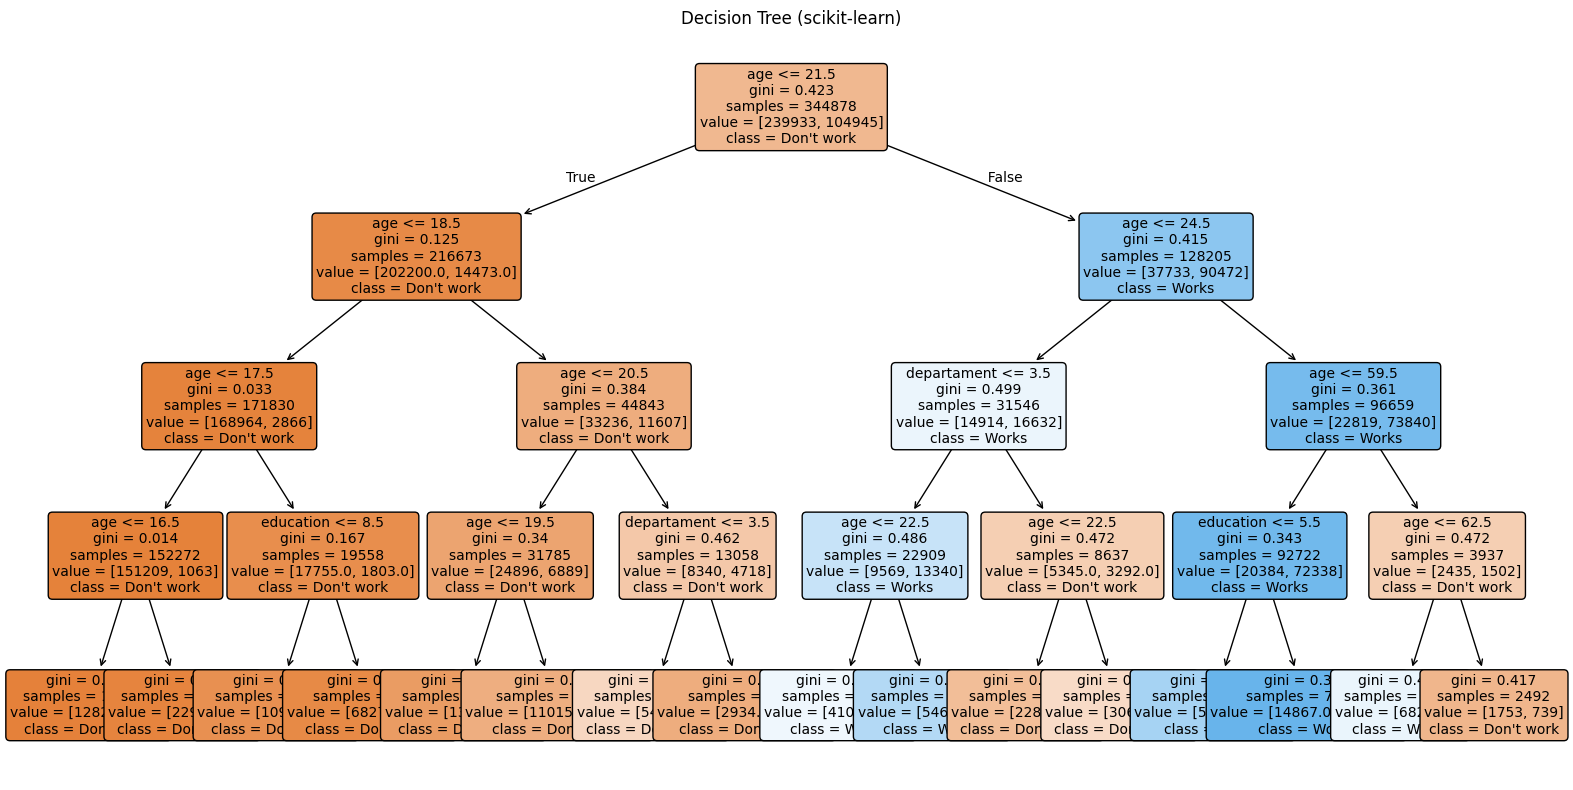

In [18]:
assembler_only = VectorAssembler(
    inputCols=FEATURES,   
    outputCol="features"
)

train_features_df = assembler_only.transform(train_df)

train_pd = train_features_df.select("features", "label").toPandas()

X = np.vstack(train_pd["features"].apply(lambda v: np.array(v)))
y = train_pd["label"].astype(int).to_numpy()

clf = SkDecisionTreeClassifier(
    criterion="gini",
    max_depth=4,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

clf.fit(X, y)

plt.figure(figsize=(16, 8))
plot_tree(
    clf,
    filled=True,

    feature_names=["age", "sex", "education", "departament"],
    class_names=["Don't work", "Works"],
    rounded=True,
    fontsize=10
)

plt.title("Decision Tree (scikit-learn)")
plt.tight_layout()

plt.savefig("results/decision_tree.png", dpi=300, bbox_inches="tight")

plt.show()

plt.close()  

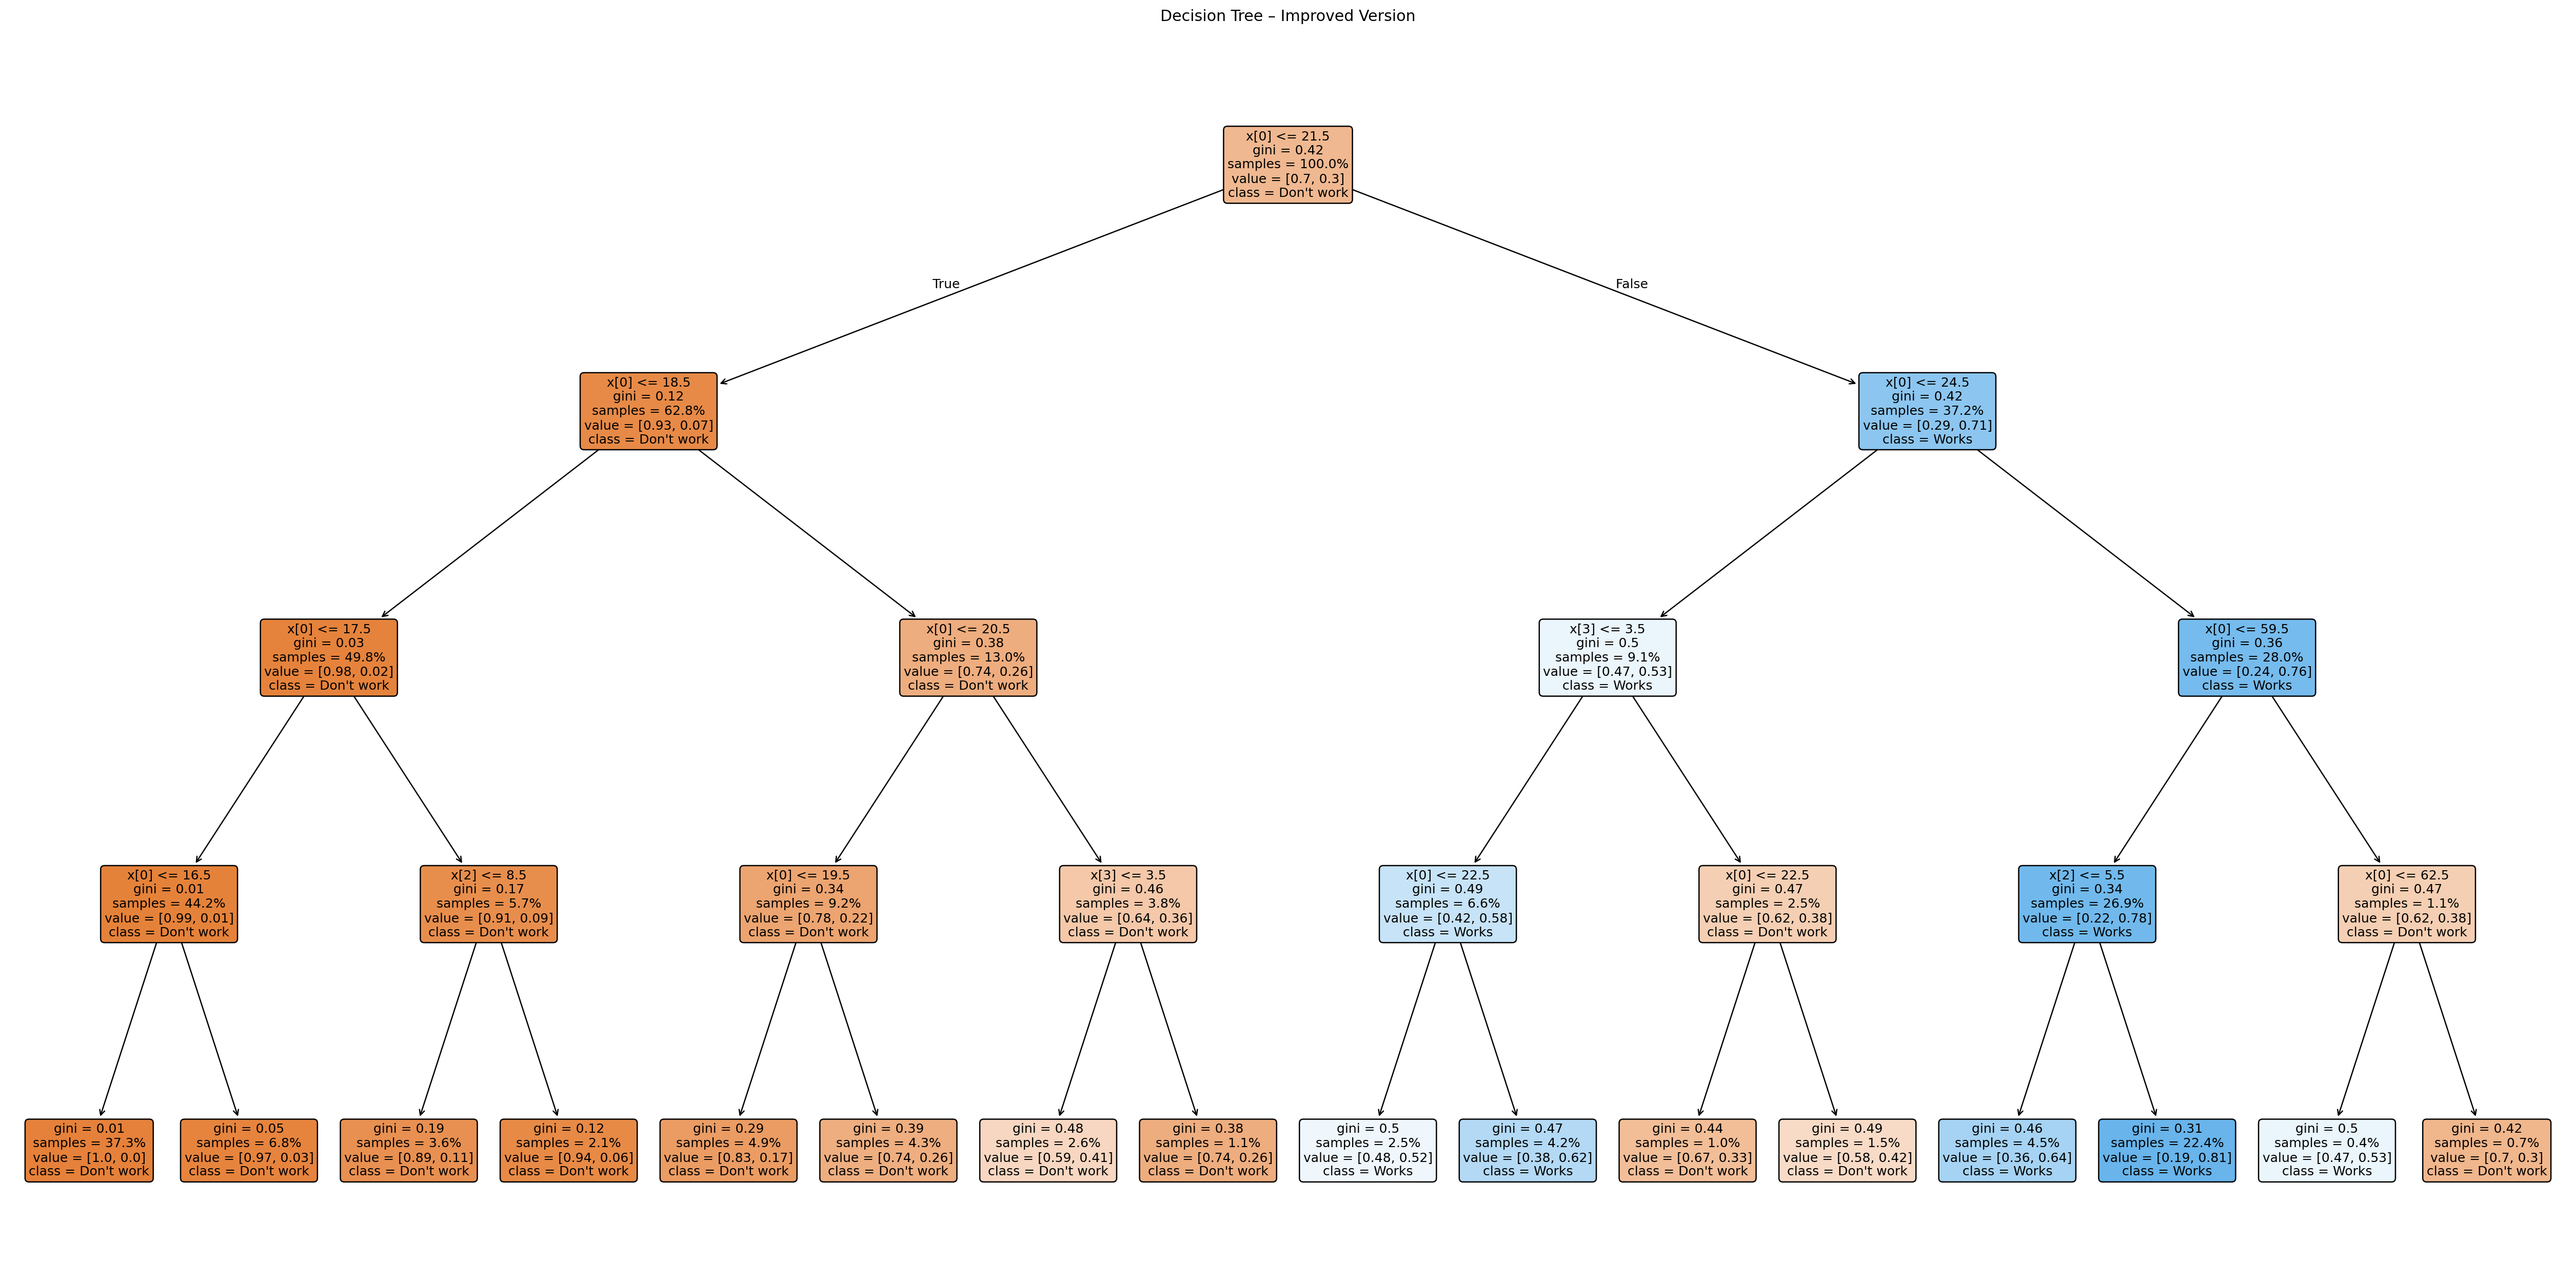

In [19]:
plt.figure(figsize=(28, 14), dpi=180)

plot_tree(
    clf,
    feature_names=["age", "sex", "education", "departament"] if X.shape[1] == 3 else None,
    class_names=["Don't work", "Works"],
    filled=True,
    rounded=True,
    proportion=True,
    precision=2,
    fontsize=10
)

plt.title("Decision Tree – Improved Version", pad=16)
plt.margins(x=0.02, y=0.05)
plt.tight_layout()

plt.savefig(
    "decision_tree_mejorado.png",
    bbox_inches="tight",
    pad_inches=0.4,
    dpi=300
)

plt.savefig(
    "results/decision_tree_mejorado.png",
    bbox_inches="tight",
    pad_inches=0.4,
    dpi=300
)

plt.show()


The decision tree shows how a small set of demographic features is used to predict whether a person works. Although the feature names appear encoded, the main patterns are clear.

**1. age is the main driver**
The first split occurs around age ~21.5:
- age ≤ 21.5 → mostly predicted as "does not work"
- age > 21.5 → higher probability of working

This matches the typical labor trend: younger individuals are more likely to be studying and not yet active in the labor force.

**2. very young individuals rarely work**
People aged 16–18 almost always fall into the "does not work" branch. Even up to ~20, the likelihood of working remains low. This aligns with extended schooling and low youth employment.

**3. education refines predictions**
After age, education contributes to several splits:
- lower education → more likely not working  
- higher education → increased probability of working

This reflects well-established links between education and employability.

**4. adults (25–60) show higher employment probability**
Most splits in the older age range shift strongly toward the "works" class. Education and other encoded variables adjust this probability but the overall trend is consistent.

**5. some older individuals still fall into "does not work"**
Certain combinations of low education or specific encoded categories lead to predictions of non-employment even among older adults. These may reflect regional or socioeconomic differences.

**6. the tree captures non-linear patterns**
The model highlights:
- threshold effects (e.g., age < 17)
- interactions between age and education
- small regional or categorical variations

This gives interpretable, rule-based insights that complement logistic regression.

**summary**
The tree indicates:
- age is the strongest predictor  
- employment likelihood rises sharply after early adulthood  
- education meaningfully improves predictions  
- regional or encoded factors add fine-grained splits  



## **9. Feature importance**

In [20]:
pd.DataFrame({
    "feature": FEATURES,
    "importance": dt_model.stages[-1].featureImportances.toArray()
}).sort_values("importance", ascending=False)



,feature,importance
0,age,0.968592
2,education,0.023940
3,departament,0.007468
1,sex,0.000000


### key findings
- **age**  
  Age is by far the most important feature. Almost all the predictive structure in the tree comes from age-based splits. This confirms what we saw in the tree visualization: employment status is strongly driven by age.

- **education**  
  Education has a small but meaningful contribution. It helps refine predictions after age, especially for adults.

- **departament**  
  Department has very limited influence. Regional differences exist, but they contribute little to the overall model.

- **sex**  
  Sex adds no predictive value in this decision tree. The model did not find meaningful splits based on this feature.

The decision tree relies almost entirely on **age**, with minor adjustments from **education** and **department**. Other features play virtually no role in the model’s decisions.


In [21]:
spark.stop()